# Chapter 1. Gaining Early Insights from Textual Data

In [86]:
from pathlib import Path
import pandas as pd

import seaborn as sns
sns.set()

In [87]:
DATASET = Path("../DATASETS/1/un-general-debates-blueprint.csv")

In [88]:
df = pd.read_csv(DATASET)
df.sample(4)

,session,year,country,country_name,speaker,position,text
4249,53,1998,SVK,Slovakia,Zdenka Kramplová,Minister for Foreign Affairs,"First of all, I wish to\ncongratulate the Pres..."
3907,51,1996,UGA,Uganda,Eriya Kategaya,Deputy Prime Minister,﻿It is a pleasure and an\nhonour for me to add...
4776,56,2001,PRT,Portugal,Jaime Gama,UN Representative,﻿English text furnished by the delegation): It...
7107,68,2013,USA,United States,Barack Obama,President,Each year we come together to \nreaffirm the f...


## Getting an overview of the Data with pandas

* Calculate summary statistics.
* Check for missing values.
* Plot distributions of interesting attributes.
* Compare distributions across categories.
* Visualize developments over time.

### Calculating Summary Statistics for Columns

In [89]:
df["length"] = df["text"].str.len()
df.describe().T # dataset contain speaches from the 25th to the 70th un debates (1970 - 2015)

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [90]:
df[["country", "speaker"]].describe(include='O').T # The dataset contain 199 unique countries & 

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


In [91]:
# Checking missing values
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [92]:
# we need to replace the missing value with some generic values

df['speaker'].fillna("unknown", inplace=True)

In [93]:
# there is a chance, the speaker's name is spelled differently.
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

### Plotting Value Distributions

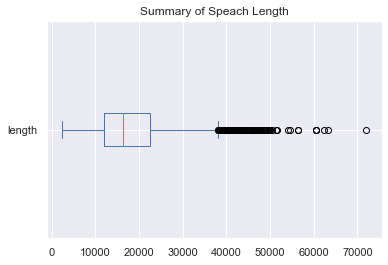

In [94]:
df["length"].plot(kind="box", vert=False, title="Summary of Speach Length");
# 50% of the speaches have a length rougly 12000 and 22000, with the median at about 16000.

<AxesSubplot:ylabel='Frequency'>

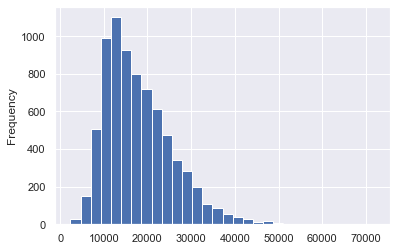

In [95]:
df["length"].plot(kind="hist", bins=30)

### Comparing Value Distributions Across Categories

In [96]:
# Peculiarities in the data often become visible when different subsets of the data are examined

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS', 'IND'])

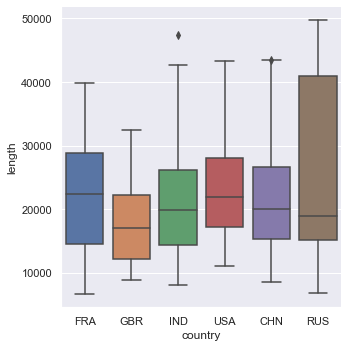

In [97]:
sns.catplot(data=df[where], x='country', y='length', kind='box');

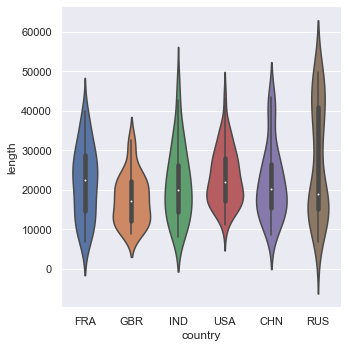

In [98]:
sns.catplot(data=df[where], x='country', y='length', kind='violin')
# RUS is much larger than for GBR but existence of multiple peaks, 
# as in Russia, only becomes apparent in the violin plot.

### Visualizing Developments Over Time

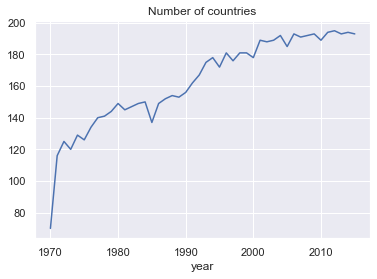

In [99]:
df.groupby('year').size().plot(title="Number of countries");

# this reflects the development of UN in each year.

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

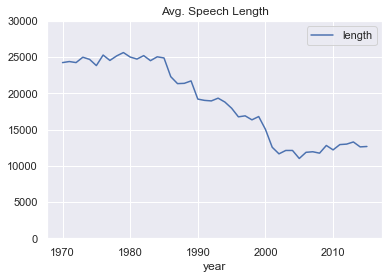

In [100]:
df.groupby('year').agg({'length': 'mean'}).plot(title="Avg. Speech Length", ylim=(0,30000))

#the speech length needed to decrease with more countries entering the debates

## Building a Simple Text Preprocessing Pipeline


### Performing Tokenization with Regular Expressions

In [103]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [104]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


### Treating Stopwords

In [105]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [106]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [107]:
include_stopwords = {"dear", "regards", "must", "would", "also"}
exclude_stopwords = {"against"}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

### Processing a Pipeline with One Line of Code

In [108]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [109]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [110]:
df['num_tokens'] = df['tokens'].map(len)

## Blueprints for Word Frequency Analysis

### Counting Words with a Counter

In [111]:
from collections import Counter

In [112]:
tokens = tokenize("She likes my cats and my cats like my sofa")

In [113]:
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [114]:
# Counter can be incrementally updated

more_token = tokenize("She likes my dogs too")
counter.update(more_token)

In [115]:
print(counter)

Counter({'my': 4, 'She': 2, 'likes': 2, 'cats': 2, 'and': 1, 'like': 1, 'sofa': 1, 'dogs': 1, 'too': 1})


In [ ]:
counter = Counter()

df['tokens'].map(counter.update)

In [118]:
print(counter.most_common(4))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421)]


In [132]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [133]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [134]:
count_words(df, column='text', 
        preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
enfranchising,2
interrelate,2
compositions,2


### Creating a Frequency Diagram

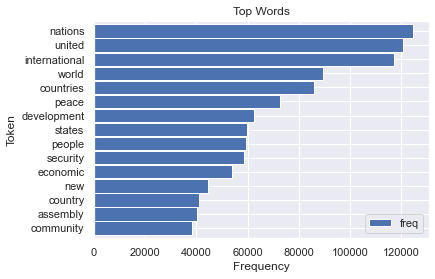

In [143]:
ax = freq_df.head(15).plot(kind="barh", width=.95)

ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words');

### Creating Word Clouds

In [144]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [172]:
text = df.query("year==2015 and country=='USA'")['text'].values[0]

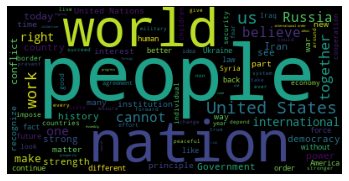

In [173]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)

plt.imshow(wc)
plt.axis("off");

In [186]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

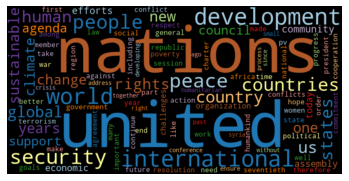

In [188]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)

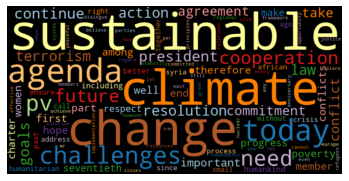

In [191]:
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)